In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import yaml
from torch import nn
import timm
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

In [50]:
# TODO: add GradCam ++
import plotly.express as px


def return_filpath(name, folder):
    """
    This function is used to return the file path of the image.
    :param name:
    :param folder:
    :return:
    """
    path = os.path.join(folder, f'{name}')
    return path


device = torch.device('cpu')
oof = pd.read_csv('/home/mithil/PycharmProjects/Cultivar_FGVC9/oof/tf_efficientnetv2_m_tta_oof.csv')
oof_probability = np.load('/home/mithil/PycharmProjects/Cultivar_FGVC9/oof/tf_efficientnetv2_m_tta_oof_probablity.npy')
oof['file_path'] = oof['image_id'].apply(
    lambda x: return_filpath(x, folder='/home/mithil/PycharmProjects/Cultivar_FGVC9/data/archive/train'))
images_path = oof['file_path'].values
ids = {}
truth_ids = []
for i, (pred, truth, pred_int) in enumerate(zip(oof['prediction'].values, oof['cultivar'].values, oof['cultivar_int'])):
    if pred != truth:
        ids.update({i: oof['file_path'].values[i]})
        truth_ids.append(truth)
print(len(ids))

wrong_preds_df = pd.DataFrame.from_dict(ids, orient='index')
wrong_preds_df['cultivar'] = truth_ids
wrong_ids = wrong_preds_df['cultivar'].value_counts().to_dict()
print(wrong_ids)
dict = {'x': list(wrong_ids.keys()), 'y': list(wrong_ids.values())}
fig = px.bar(dict, x='x', y='y', title='Wrong Predictions')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/wrong_prediction.html")


292
{'PI_154944': 54, 'PI_329300': 44, 'PI_329301': 33, 'PI_146890': 33, 'PI_276837': 19, 'PI_253986': 16, 'PI_154844': 13, 'PI_329299': 9, 'PI_175919': 8, 'PI_152730': 8, 'PI_155760': 7, 'PI_157030': 6, 'PI_221548': 5, 'PI_152751': 4, 'PI_155516': 2, 'PI_156487': 2, 'PI_152694': 2, 'PI_152971': 2, 'PI_157035': 2, 'PI_152860': 2, 'PI_167093': 2, 'PI_329310': 1, 'PI_297155': 1, 'PI_267573': 1, 'PI_153877': 1, 'PI_63715': 1, 'PI_273465': 1, 'PI_152862': 1, 'PI_35038': 1, 'PI_156393': 1, 'PI_257599': 1, 'PI_145619': 1, 'PI_197542': 1, 'PI_152961': 1, 'PI_152828': 1, 'PI_303658': 1, 'PI_152771': 1, 'PI_152733': 1, 'PI_221651': 1, 'PI_196049': 1}


In [51]:
dict = {}
for i in range(1, 11):
    dict[str((i / 10))] = 0

for i in oof_probability:
    dict[str((round(np.max(i), 1)))] += 1
print(dict)

test_probability = np.load(
    '/home/mithil/PycharmProjects/Cultivar_FGVC9/submissions/tta/effnetv2_m_25epoch_probablity.npy')
dict_1 = {}
for i in range(1, 11):
    dict_1[str((i / 10))] = 0

for i in test_probability:
    dict_1[str((round(np.max(i), 1)))] += 1
print(dict_1)


{'0.1': 1, '0.2': 2, '0.3': 56, '0.4': 178, '0.5': 330, '0.6': 582, '0.7': 1166, '0.8': 2237, '0.9': 3894, '1.0': 13747}
{'0.1': 24, '0.2': 300, '0.3': 646, '0.4': 1008, '0.5': 1392, '0.6': 1598, '0.7': 2202, '0.8': 3529, '0.9': 8487, '1.0': 4453}


In [52]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Train', x=list(dict_1.keys()), y=list(dict.values())),
    go.Bar(name='Test', x=list(dict_1.keys()), y=list(dict_1.values()))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/train_test_confidence.html")


In [53]:
train_df = pd.read_csv('/home/mithil/PycharmProjects/Cultivar_FGVC9/data/archive/train_cultivar_mapping.csv')
train_distribution = train_df['cultivar'].value_counts().to_dict()
dict = {'x': list(train_distribution.keys()), 'y': list(train_distribution.values())}
fig = px.bar(dict, x='x', y='y', title='Train Distribution')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/train_distribution.html")


Now We will Do eda on prediction of the test set.
First we will take our highest model score sub and check its distribution
Second we will take a lower model score sub and check its distribution


In [54]:
import plotly.graph_objects as go

test_df = pd.read_csv(
    '/home/mithil/PycharmProjects/Cultivar_FGVC9/submissions/tta/tf_efficientnetv2_m_896_cutmix_h_1(is896 7xTTa pseudo_label)__wo_out.csv')
test_distribution = test_df['cultivar'].value_counts().to_dict()
dict_test = {'x': list(test_distribution.keys()), 'y': list(test_distribution.values())}
fig = px.bar(dict_test, x='x', y='y', title='Test Distribution')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/test_distribution.html")

sorted(train_distribution.items())
sorted(test_distribution.items())
fig = go.Figure(data=[
    go.Bar(name='Train', x=list(train_distribution.keys()), y=list(train_distribution.values())),
    go.Bar(name='Test', x=list(train_distribution.keys()), y=list(test_distribution.values()))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/train_test_distribution.html")

#### Comparing our model train vs test distribution
#### We can see that it likes to predict more of the classes that are not highly represented in the test set

We infer that model which is closer to the train distribution has a higher score , So we should focus on predicting the underrepresented class more .

In [55]:
test_df = pd.read_csv('/home/mithil/PycharmProjects/Cultivar_FGVC9/submissions/tta/effnetv2_m_25epoch_probablity.csv')
test_distribution = test_df['cultivar'].value_counts().to_dict()
dict_test = {'x': list(test_distribution.keys()), 'y': list(test_distribution.values())}
fig = px.bar(dict_test, x='x', y='y', title='Test Distribution')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/test_distribution_lower_score.html")
sorted(train_distribution.items())
sorted(test_distribution.items())
fig = go.Figure(data=[
    go.Bar(name='Train', x=list(train_distribution.keys()), y=list(train_distribution.values())),
    go.Bar(name='Test', x=list(train_distribution.keys()), y=list(test_distribution.values()))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()
fig.write_html("/home/mithil/PycharmProjects/Cultivar_FGVC9/plots/est_distribution_lower_score.html")


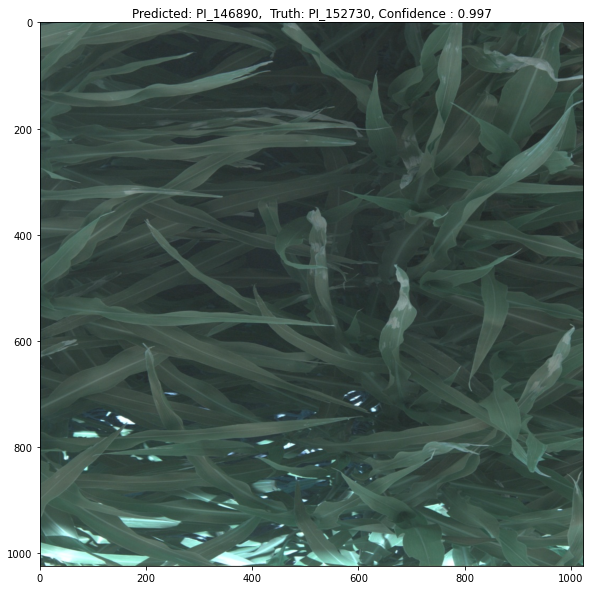

In [56]:
import time

for key, values in ids.items():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots(1, 1)
    img = cv2.imread(values)

    ax.imshow(img)
    ax.set_title(
        f'Predicted: {oof["prediction"].values[key]},  Truth: {oof["cultivar"].values[key]}, Confidence : {np.max(oof_probability[key]):.3f}')
    plt.show()

    time.sleep(5)
    break


In [57]:
from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    print(i, flush=True)

9
